In this notebook I will try to harness the power of trasnfer learning and see how well does it perform on cats and dogs dataset.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-10f67796-fee7-928e-5d30-81964ce027d0)


# Importing and Preprocessing data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [52]:
# !unzip gdrive/MyDrive/archive.zip

In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("training_set"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in 'training_set'.
There are 2 directories and 0 images in 'training_set/training_set'.
There are 0 directories and 4001 images in 'training_set/training_set/cats'.
There are 0 directories and 4006 images in 'training_set/training_set/dogs'.


In [5]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("test_set"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in 'test_set'.
There are 2 directories and 0 images in 'test_set/test_set'.
There are 0 directories and 1012 images in 'test_set/test_set/cats'.
There are 0 directories and 1013 images in 'test_set/test_set/dogs'.


In [6]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)

class_names = [ item for item in os.listdir('test_set/test_set') if os.path.isdir(os.path.join("test_set/test_set", item)) ]
print(class_names)

['cats', 'dogs']


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "training_set/training_set/"
test_dir = "test_set/test_set/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

test_data = valid_datagen.flow_from_directory(test_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode="binary",
                                              seed=42)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [8]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Model URLs

These URLs are taken from [Tensorflow Hub](https://tfhub.dev/) which has thousands of pretrained models which have performed quite well on datasets far larger than ours.

You can filter out the search results for your own domain and pick the model that fits your data set.

I have picked Resnet version 1 and Efficientnet version 2 as both these models are trained on images of size (224, 224) which is the size in which we preprocessed our images so these models are expected to perform good on our dataset. Let's see.....

In [10]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [11]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

def create_model(model_url):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

# Resnet Model

In [12]:
# Create model
resnet_model = create_model(resnet_url)

# Compile
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [13]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220610-164148
Epoch 1/5
251/251 [==============================] - 52s 149ms/step - loss: 0.1000 - accuracy: 0.9634 - val_loss: 0.0612 - val_accuracy: 0.9792
Epoch 2/5
251/251 [==============================] - 37s 147ms/step - loss: 0.0460 - accuracy: 0.9850 - val_loss: 0.0554 - val_accuracy: 0.9827
Epoch 3/5
251/251 [==============================] - 37s 149ms/step - loss: 0.0362 - accuracy: 0.9875 - val_loss: 0.0483 - val_accuracy: 0.9827
Epoch 4/5
251/251 [==============================] - 36s 144ms/step - loss: 0.0312 - accuracy: 0.9896 - val_loss: 0.0477 - val_accuracy: 0.9857
Epoch 5/5
251/251 [==============================] - 36s 144ms/step - loss: 0.0277 - accuracy: 0.9905 - val_loss: 0.0460 - val_accuracy: 0.9827


In [14]:
score = resnet_model.evaluate(test_data, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.046003613620996475
Validation accuracy: 0.9826989769935608


In [15]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

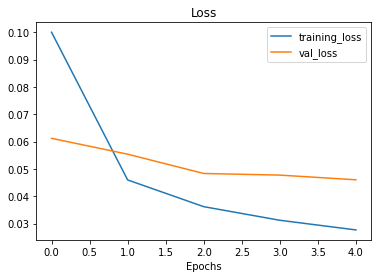

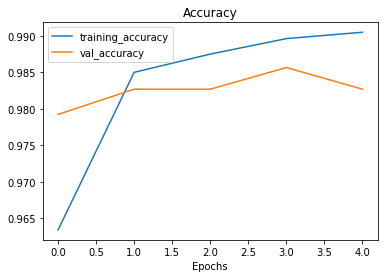

In [16]:
plot_loss_curves(resnet_history)

# Efficientnet Model

In [17]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url)

# Compile EfficientNet model
efficientnet_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220610-164520
Epoch 1/5
251/251 [==============================] - 43s 144ms/step - loss: 0.1275 - accuracy: 0.9655 - val_loss: 0.0604 - val_accuracy: 0.9827
Epoch 2/5
251/251 [==============================] - 34s 135ms/step - loss: 0.0510 - accuracy: 0.9829 - val_loss: 0.0466 - val_accuracy: 0.9847
Epoch 3/5
251/251 [==============================] - 34s 134ms/step - loss: 0.0408 - accuracy: 0.9863 - val_loss: 0.0420 - val_accuracy: 0.9867
Epoch 4/5
251/251 [==============================] - 34s 134ms/step - loss: 0.0355 - accuracy: 0.9878 - val_loss: 0.0402 - val_accuracy: 0.9867
Epoch 5/5
251/251 [==============================] - 33s 133ms/step - loss: 0.0317 - accuracy: 0.9894 - val_loss: 0.0410 - val_accuracy: 0.9871


In [49]:
efficientnet_score = resnet_model.evaluate(test_data, verbose=0)
print('Validation loss:', efficientnet_score[0])
print('Validation accuracy:', efficientnet_score[1])

Validation loss: 0.046003617346286774
Validation accuracy: 0.9826989769935608


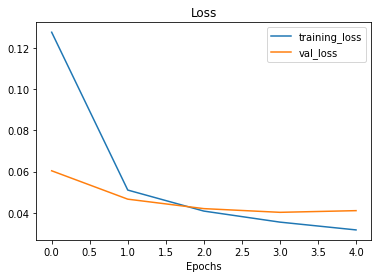

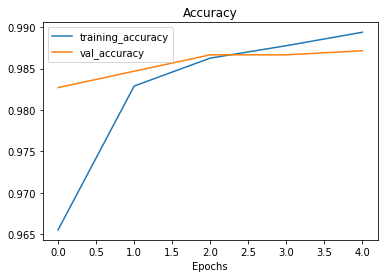

In [42]:
plot_loss_curves(efficientnet_history)

# Mobilenet model

Above two models performed almost perfectly, but there are other models as well who are known to perform amazingly on image dataset.

Here i chose a random version of mobilenet model from tensorflow hub, checked whether its input size is compatible and then tried it on our dataset.

In [46]:
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [48]:
# Create model
mobilenet_model = create_model(model_url=mobilenet_url)

# Compile EfficientNet model
mobilenet_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
mobilenet_history = mobilenet_model.fit(train_data, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="mobilenet")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet/20220610-173749
Epoch 1/5
251/251 [==============================] - 39s 141ms/step - loss: 0.1074 - accuracy: 0.9644 - val_loss: 0.0440 - val_accuracy: 0.9896
Epoch 2/5
251/251 [==============================] - 35s 140ms/step - loss: 0.0438 - accuracy: 0.9841 - val_loss: 0.0342 - val_accuracy: 0.9911
Epoch 3/5
251/251 [==============================] - 34s 137ms/step - loss: 0.0361 - accuracy: 0.9883 - val_loss: 0.0355 - val_accuracy: 0.9891
Epoch 4/5
251/251 [==============================] - 34s 134ms/step - loss: 0.0319 - accuracy: 0.9900 - val_loss: 0.0335 - val_accuracy: 0.9891
Epoch 5/5
251/251 [==============================] - 38s 153ms/step - loss: 0.0278 - accuracy: 0.9914 - val_loss: 0.0292 - val_accuracy: 0.9926


In [50]:
mobilenet_score = mobilenet_model.evaluate(test_data, verbose=0)
print('Validation loss:', mobilenet_score[0])
print('Validation accuracy:', mobilenet_score[1])

Validation loss: 0.029206395149230957
Validation accuracy: 0.9925852417945862


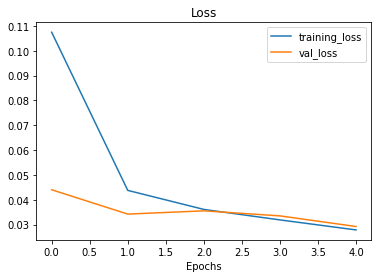

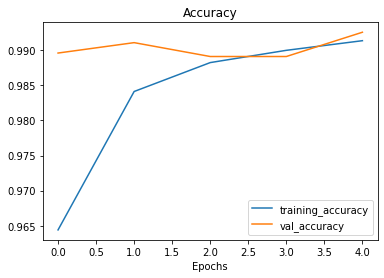

In [51]:
plot_loss_curves(mobilenet_history)

Its evident that pretrained models are far far better than the ones we created ourselvs and this is the power of transfer learning.